In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, accuracy_score, precision_score, 
                             recall_score, f1_score)
from matplotlib.colors import LinearSegmentedColormap

In [2]:
THEME_COLORS = {
    'primary_navy': '#1F3A5F',  # Deep Navy (Trust/Stability) - Class 0 (No)
    'accent_gold': '#C5A065',   # Muted Gold (Wealth/Success) - Class 1 (Yes)
    'neutral_grey': '#E6E6E6',  # Backgrounds
    'text_dark': '#2C3E50'
}

In [3]:
# BUSINESS VARIABLES (Change these based on your specific costs)
# This helps decide the threshold based on Profit, not just Accuracy.
COST_PER_CALL = 10          # Example: It costs $10 wage/time to make a call
REVENUE_PER_DEAL = 150      # Example: A successful deposit earns the bank $150 LTV

In [4]:
df = pd.read_csv('data/bank-additional-full.csv', sep=';')
df = df.drop_duplicates()

# Drop multicollinearity features
df = df.drop(['emp.var.rate', 'nr.employed'], axis=1)
df = df.drop(['duration'], axis=1)

# Separate features and target
X = df.drop('y', axis=1)
y = df['y'].map({'no': 0, 'yes': 1})
print(f"Dataset shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Dataset shape: (41176, 17)
Target distribution: {0: 36537, 1: 4639}


In [5]:
# Cell 3: Encode Categorical Variables
categorical_cols = X.select_dtypes(include='object').columns.tolist()
le_dict = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    le_dict[col] = le

print(f"\nCategorical columns encoded: {len(categorical_cols)}")


Categorical columns encoded: 10


In [6]:
# Cell 4: Train-Test Split (NO scaling needed for Decision Tree)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)
print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Train set size: 32940
Test set size: 8236


In [7]:
# Cell 5: Train Decision Tree with Hyperparameter Tuning
# Limited depth to improve interpretability and avoid overfitting
dt_classifier = DecisionTreeClassifier(
    max_depth=7,  # Limit depth for interpretability
    min_samples_split=50,  # Require at least 50 samples to split
    min_samples_leaf=20,  # Require at least 20 samples in leaf nodes
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    criterion='entropy'
)
dt_classifier.fit(X_train, y_train)
print("Decision Tree trained successfully!")

Decision Tree trained successfully!


In [8]:
y_pred = dt_classifier.predict(X_test)
y_prob = dt_classifier.predict_proba(X_test)[:, 1]

In [10]:
clean_names = []
for col in X.columns:
    name = col.replace('.', ' ').replace('_', ' ').title()
    # Specific overrides for clarity
    if "Euribor3M" in name or "Euribor3m" in name: name = "Euribor 3-Month Rate"
    if "Cons Conf Idx" in name: name = "Consumer Conf. Index"
    if "Cons Price Idx" in name: name = "Consumer Price Index"
    if "Poutcome" in name: name = "Previous Campaign Outcome"
    if "Pdays" in name: name = "Days Since Last Contact"
    clean_names.append(name)

# Custom Color Map for the Tree (Navy to Gold)
# Gradient from Class 0 (Navy) to Class 1 (Gold)
colors = [THEME_COLORS['primary_navy'], "#F0F0F0", THEME_COLORS['accent_gold']]
custom_cmap = LinearSegmentedColormap.from_list("BankTheme", colors)

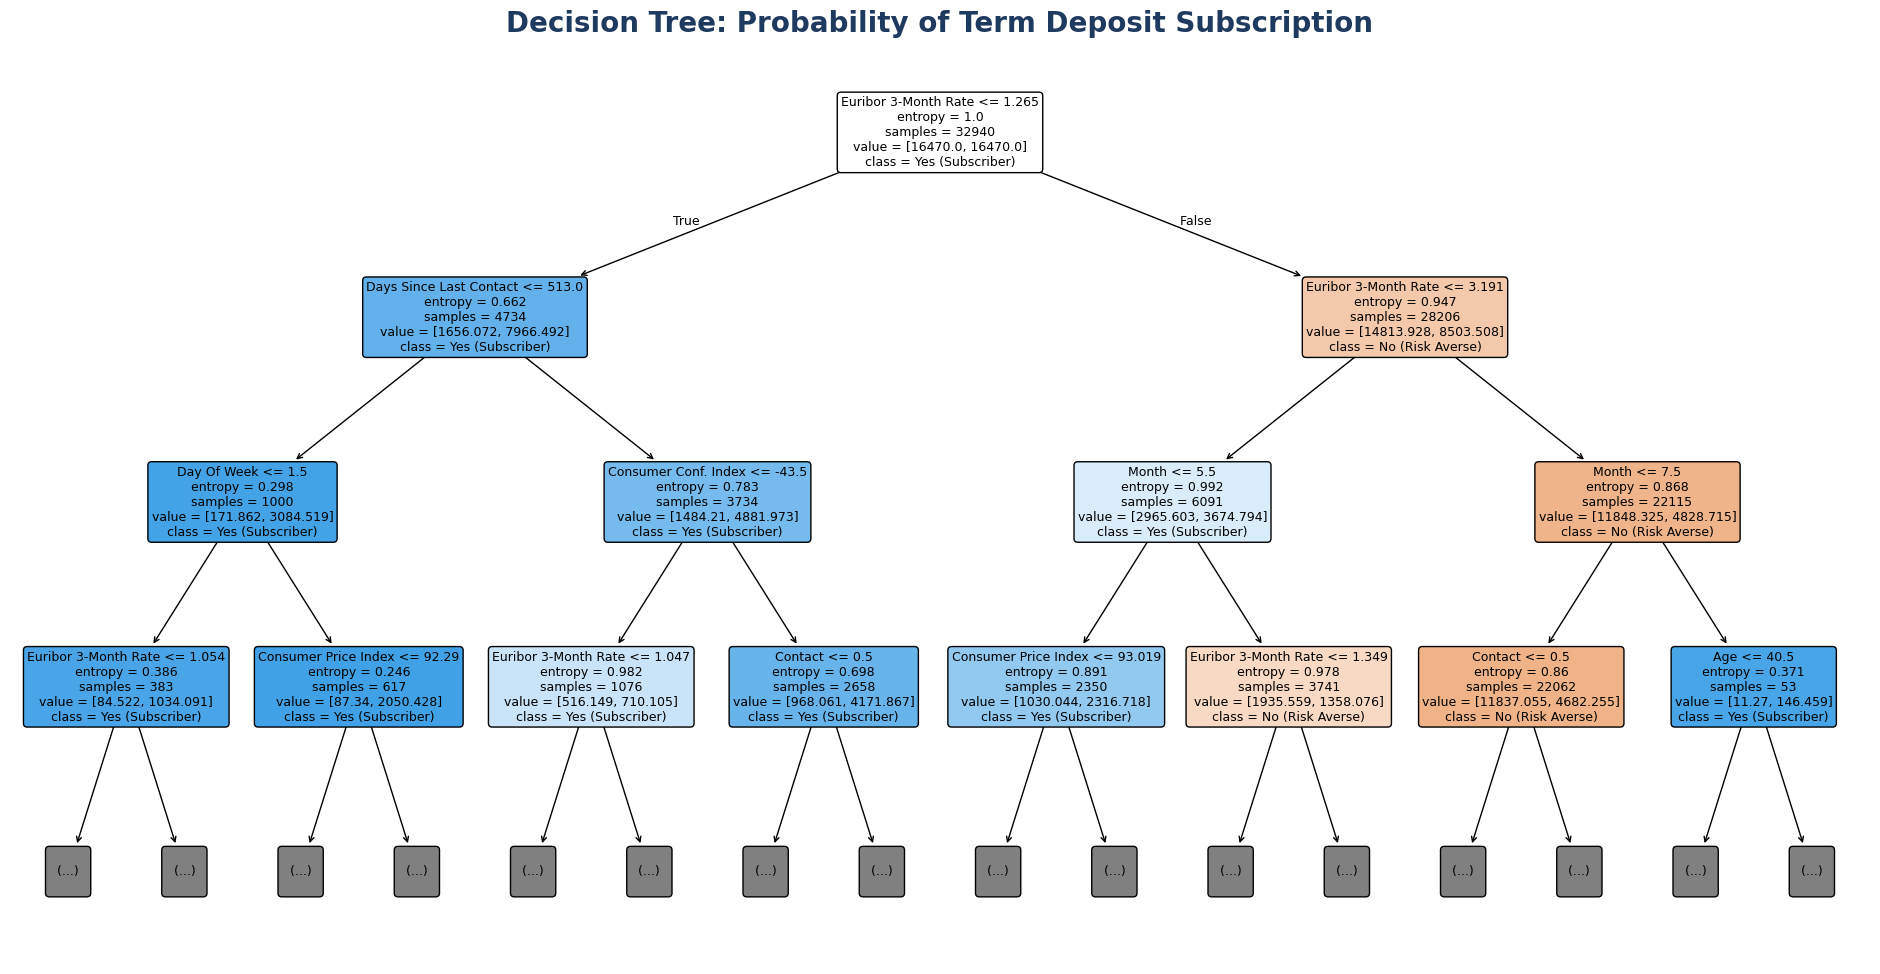

In [12]:
plt.figure(figsize=(24, 12))
plot_tree(
    dt_classifier, 
    feature_names=clean_names,  
    class_names=["No (Risk Averse)", "Yes (Subscriber)"],
    filled=True, 
    rounded=True, 
    fontsize=9,
    max_depth=3  # Limiting depth for display clarity, though model is depth 7
)
plt.title("Decision Tree: Probability of Term Deposit Subscription", 
            fontsize=20, color=THEME_COLORS['primary_navy'], fontweight='bold')
plt.savefig("bank_decision_tree_aesthetic.png", dpi=300)
plt.show()


FEATURE IMPORTANCE (Top 10 Drivers)
                Feature  Importance
   Euribor 3-Month Rate    0.723385
                  Month    0.070906
Days Since Last Contact    0.059893
                Contact    0.030070
   Consumer Price Index    0.029158
   Consumer Conf. Index    0.023887
            Day Of Week    0.018029
                    Age    0.014561
               Campaign    0.013837
               Previous    0.007448


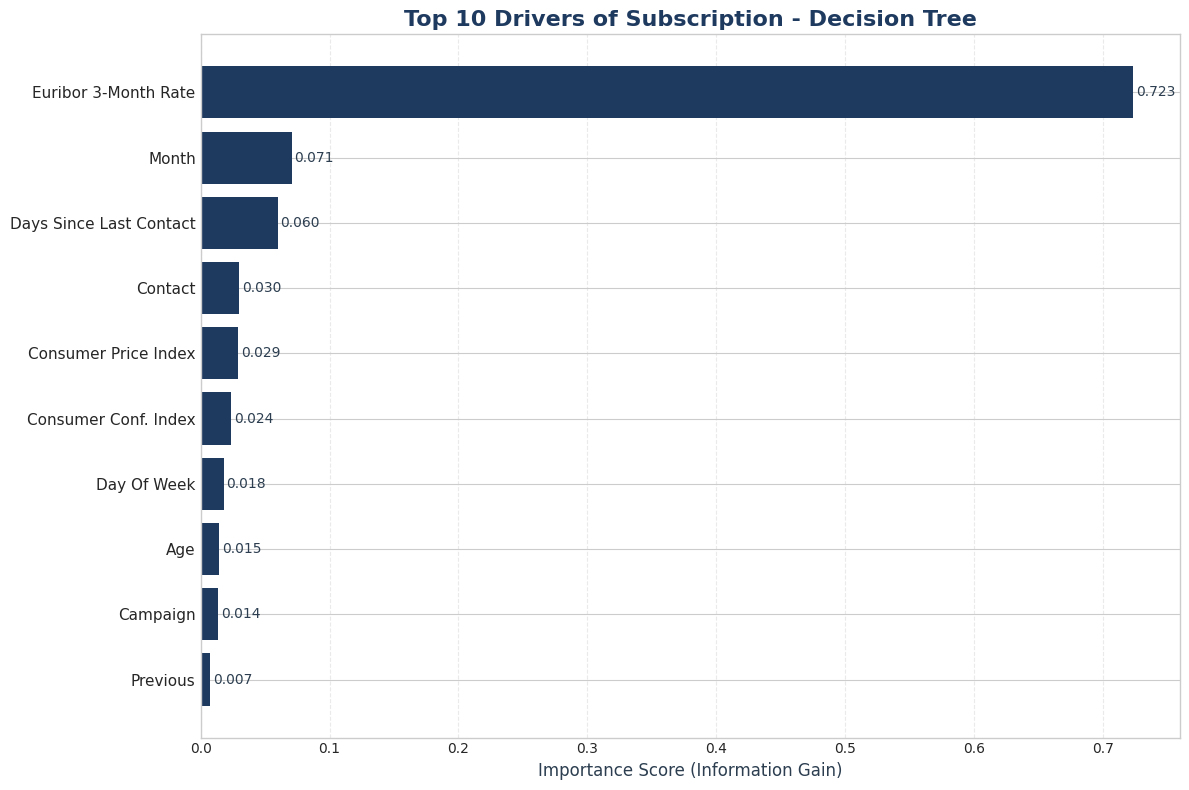

In [23]:
# --- B. FEATURE IMPORTANCE PLOT (RESTORED & STYLED) ---
feature_importance = dt_classifier.feature_importances_

# Create DataFrame with CLEAN names
importance_df = pd.DataFrame({
    'Feature': clean_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("FEATURE IMPORTANCE (Top 10 Drivers)")
print("="*60)
print(importance_df.head(10).to_string(index=False))

# Plotting
plt.figure(figsize=(12, 8))
top_n = 10
top_features = importance_df.head(top_n).sort_values('Importance', ascending=True) # Sort for horizontal bar

bars = plt.barh(range(len(top_features)), top_features['Importance'], color=THEME_COLORS['primary_navy'])

# Style adjustments
plt.yticks(range(len(top_features)), top_features['Feature'], fontsize=11)
plt.xlabel('Importance Score (Information Gain)', fontsize=12, color=THEME_COLORS['text_dark'])
plt.title('Top 10 Drivers of Subscription - Decision Tree', fontweight='bold', fontsize=16, color=THEME_COLORS['primary_navy'])

# Add subtle grid and values on bars
plt.grid(axis='x', linestyle='--', alpha=0.4)
for i, v in enumerate(top_features['Importance']):
    plt.text(v + 0.002, i, f"{v:.3f}", va='center', fontsize=10, color=THEME_COLORS['text_dark'])

plt.tight_layout()
plt.savefig("bank_feature_importance.png", dpi=300)
plt.show()


PROFITABILITY ANALYSIS & THRESHOLD OPTIMIZATION


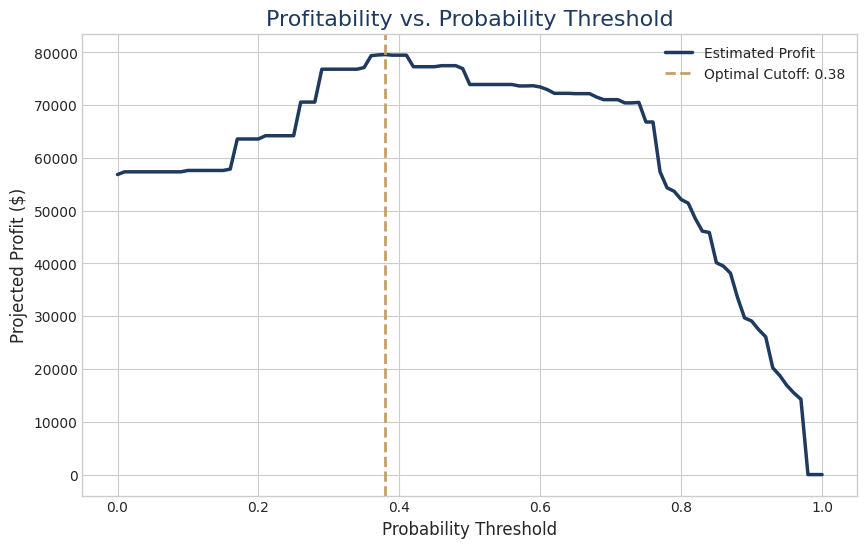


OPTIMAL THRESHOLD CALCULATED: 0.38
Projected Max Profit: $79,560.00


In [25]:
 
    print("\n" + "="*60)
    print("PROFITABILITY ANALYSIS & THRESHOLD OPTIMIZATION")
    print("="*60)
    
    thresholds = np.arange(0.0, 1.01, 0.01)
    profits = []

    for t in thresholds:
        y_pred_t = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
        
        calls_made = tp + fp
        total_revenue = tp * REVENUE_PER_DEAL
        total_cost = calls_made * COST_PER_CALL
        net_profit = total_revenue - total_cost
        profits.append(net_profit)

    max_profit = max(profits)
    optimal_idx = np.argmax(profits)
    optimal_threshold = thresholds[optimal_idx]

    # Profit Curve Plot
    plt.figure(figsize=(10, 6))
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.plot(thresholds, profits, color=THEME_COLORS['primary_navy'], linewidth=2.5, label='Estimated Profit')
    plt.axvline(optimal_threshold, color=THEME_COLORS['accent_gold'], linestyle='--', linewidth=2, label=f'Optimal Cutoff: {optimal_threshold:.2f}')
    

    plt.title("Profitability vs. Probability Threshold", fontsize=16, color=THEME_COLORS['primary_navy'])
    plt.xlabel("Probability Threshold", fontsize=12)
    plt.ylabel("Projected Profit ($)", fontsize=12)
    plt.legend()
    plt.show()

    print(f"\nOPTIMAL THRESHOLD CALCULATED: {optimal_threshold:.2f}")
    print(f"Projected Max Profit: ${max_profit:,.2f}")


OPTIMAL THRESHOLD CALCULATED: 0.38
Projected Max Profit: $79,560.00

FINAL PERFORMANCE REPORT (at Threshold 0.38)
Metric               | Value      | Business Implication
---------------------------------------------------------------------------
Accuracy             | 0.7816     | Overall correctness of predictions
Precision            | 0.3046     | % of calls that result in a sale (Efficiency)
Recall               | 0.7317     | % of all potential buyers we managed to find
F1-Score             | 0.4302     | Balance between Efficiency and Finding Buyers
ROC-AUC              | 0.8155     | Model's ability to rank customers correctly
---------------------------------------------------------------------------

CONFUSION MATRIX BREAKDOWN:
True Negatives (Don't Call / Don't Buy): 5758 (Saved cost)
False Positives (Call / Don't Buy):      1550 (Wasted call cost)
False Negatives (Don't Call / Would Buy):249 (Lost opportunity)
True Positives (Call / Buy):             679 (Revenue generated

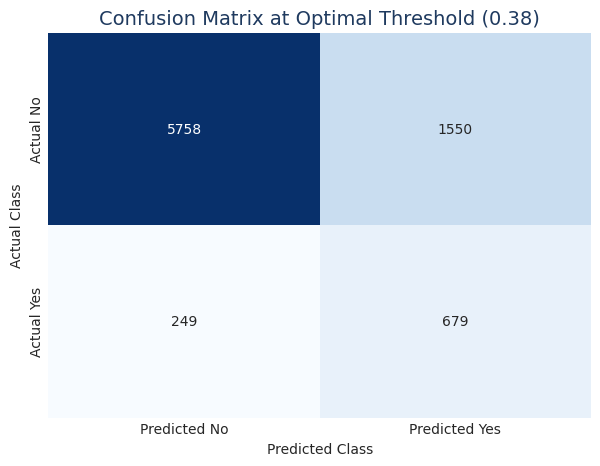

In [30]:
# --- METRICS CALCULATION AT OPTIMAL THRESHOLD ---
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

# Calculate standard metrics
acc = accuracy_score(y_test, y_pred_optimal)
prec = precision_score(y_test, y_pred_optimal)
rec = recall_score(y_test, y_pred_optimal)
f1 = f1_score(y_test, y_pred_optimal)
auc = roc_auc_score(y_test, y_prob)

# Calculate Business Metrics
cm = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = cm.ravel()

print(f"\nOPTIMAL THRESHOLD CALCULATED: {optimal_threshold:.2f}")
print(f"Projected Max Profit: ${max_profit:,.2f}")

print("\n" + "="*60)
print(f"FINAL PERFORMANCE REPORT (at Threshold {optimal_threshold:.2f})")
print("="*60)
print(f"{'Metric':<20} | {'Value':<10} | {'Business Implication'}")
print("-" * 75)
print(f"{'Accuracy':<20} | {acc:.4f}     | Overall correctness of predictions")
print(f"{'Precision':<20} | {prec:.4f}     | % of calls that result in a sale (Efficiency)")
print(f"{'Recall':<20} | {rec:.4f}     | % of all potential buyers we managed to find")
print(f"{'F1-Score':<20} | {f1:.4f}     | Balance between Efficiency and Finding Buyers")
print(f"{'ROC-AUC':<20} | {auc:.4f}     | Model's ability to rank customers correctly")
print("-" * 75)

print("\nCONFUSION MATRIX BREAKDOWN:")
print(f"True Negatives (Don't Call / Don't Buy): {tn} (Saved cost)")
print(f"False Positives (Call / Don't Buy):      {fp} (Wasted call cost)")
print(f"False Negatives (Don't Call / Would Buy):{fn} (Lost opportunity)")
print(f"True Positives (Call / Buy):             {tp} (Revenue generated)")

# Confusion Matrix Heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title(f'Confusion Matrix at Optimal Threshold ({optimal_threshold:.2f})', fontsize=14, color=THEME_COLORS['primary_navy'])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [31]:
# ==========================================
# 6. DEPLOYMENT & ROI ANALYSIS (NEXT STEPS)
# ==========================================
print("\n" + "="*60)
print("STEP 6: ROI ANALYSIS & DEPLOYMENT")
print("="*60)

# 1. CALCULATE LIFT vs BASELINE (Call Everyone)
total_clients = len(y_test)
total_actual_subscribers = sum(y_test)

# Baseline: Call Everyone
cost_baseline = total_clients * COST_PER_CALL
revenue_baseline = total_actual_subscribers * REVENUE_PER_DEAL
profit_baseline = revenue_baseline - cost_baseline

print(f"Baseline Strategy (Call Everyone):")
print(f"   -> Cost: ${cost_baseline:,.0f}")
print(f"   -> Revenue: ${revenue_baseline:,.0f}")
print(f"   -> Profit: ${profit_baseline:,.0f}")

print(f"\nModel Strategy (Threshold {optimal_threshold:.2f}):")
print(f"   -> Profit: ${max_profit:,.0f}")

lift = max_profit - profit_baseline
print(f"\n>>> TOTAL VALUE ADDED (LIFT): ${lift:,.0f}")
print("Meaning: Using this model creates this much additional profit compared to a mass-calling strategy.")



STEP 6: ROI ANALYSIS & DEPLOYMENT
Baseline Strategy (Call Everyone):
   -> Cost: $82,360
   -> Revenue: $139,200
   -> Profit: $56,840

Model Strategy (Threshold 0.38):
   -> Profit: $79,560

>>> TOTAL VALUE ADDED (LIFT): $22,720
Meaning: Using this model creates this much additional profit compared to a mass-calling strategy.


In [34]:
# 2. ADDRESSING THE PRECISION REALITY
print("\n" + "="*60)
print("STRATEGIC RECOMMENDATION: ADDRESSING PRECISION")
print("="*60)

wasted_calls = fp
wasted_cost = wasted_calls * COST_PER_CALL
percent_waste = wasted_calls / (tp + fp)

print(f"The Precision Reality: {prec:.1%} of our calls result in a sale.")
print(f"This means {percent_waste:.1%} of calls (N={wasted_calls}) are 'False Positives'.")
print(f"Financial Impact: We are spending ${wasted_cost:,.0f} calling people who say 'No'.")

print("\nRECOMMENDATION: TIERED ENGAGEMENT STRATEGY")
print("To improve ROI further, we should not treat all 'Yes' predictions equally.")
print("1. HIGH PROBABILITY (e.g., > 60%): Assign to Human Agents.")
print("   - High conversion rate justifies the $10 call cost.")
print("2. MEDIUM PROBABILITY (38% - 60%): Assign to Low-Cost Channels.")
print("   - Use Email/SMS/App Notifications first.")
print("   - Cost is ~$0.10 instead of $10.00.")
print("   - If they engage, THEN schedule a human call.")
print("-" * 60)


STRATEGIC RECOMMENDATION: ADDRESSING PRECISION
The Precision Reality: 30.5% of our calls result in a sale.
This means 69.5% of calls (N=1550) are 'False Positives'.
Financial Impact: We are spending $15,500 calling people who say 'No'.

RECOMMENDATION: TIERED ENGAGEMENT STRATEGY
To improve ROI further, we should not treat all 'Yes' predictions equally.
1. HIGH PROBABILITY (e.g., > 60%): Assign to Human Agents.
   - High conversion rate justifies the $10 call cost.
2. MEDIUM PROBABILITY (38% - 60%): Assign to Low-Cost Channels.
   - Use Email/SMS/App Notifications first.
   - Cost is ~$0.10 instead of $10.00.
   - If they engage, THEN schedule a human call.
------------------------------------------------------------
